In [1]:
import os
import pandas as pd
import oemof.solph as solph

from oemof.solph.plumbing import sequence
import datetime as dt

from oemof.outputlib import processing, views
import matplotlib.pyplot as plt

In [2]:
# function for summarize information about flows
def calc_total_flows(storage_flow, boiler_flow, total_flow, demand, schedule=None):
    total_flows = pd.DataFrame(data={"storage_flow": storage_flow[storage_flow.columns[0]],
                                    "boiler_flow": boiler_flow[boiler_flow.columns[0]]})
    if schedule:
        total_flows['schedule'] = schedule
    total_flows['total_heat_flow'] = total_flow[total_flow.columns[0]]
    total_flows['demand'] = demand["demand"]
    return total_flows

# function for preparing area plots
def prep_area_plot(df):
    stor_boil_flow = df.drop(columns=["total_heat_flow", "demand"])
    stor_boil_flow = stor_boil_flow.asfreq(freq="0.1min", method="backfill")
    columns = list(stor_boil_flow.columns)
    columns.insert(2, columns[0])
    columns.remove(columns[0])
    stor_boil_flow = stor_boil_flow.reindex(columns = columns)
    return stor_boil_flow

In [3]:
full_filename = 'test_schedule_flow.csv'
data = pd.read_csv(full_filename, sep=",")
timeindex = pd.date_range('1/1/2017', periods=8, freq='H')
periods = len(timeindex)
energysystem = solph.EnergySystem(timeindex=timeindex)

In [4]:
b_gas = solph.Bus(label = "natural_gas")
source_gas = solph.Source(label="source_gas",
                          outputs={b_gas: solph.Flow()})

energysystem.add(b_gas, source_gas)

# Adding components

Three boilers with their own demands, source, busses and storages will be added.

The three systems are not interfering with each other.


## Add regular components
- Source
- Demand
- Transformer
- GenericStorage
- Bus

without any restrictions.

In [5]:
b_th_regular = solph.Bus(label = "heat_regular")

source_th_regular = solph.Source(label='source_th_regular',
                         outputs={b_th_regular: solph.Flow(variable_costs=10000)})

demand_th_regular = solph.Sink(label='demand_th_regular', inputs={b_th_regular: solph.Flow(fixed=True,
                       actual_value=data['demand_th'], nominal_value=200)})

boiler_regular = solph.Transformer(
    label="boiler_regular",
    inputs={b_gas: solph.Flow()},
    outputs={b_th_regular: solph.Flow(nominal_value=200, variable_costs=1)},
    conversion_factors={b_th_regular: 1}
)

storage_th_regular = solph.components.GenericStorage(
    label='storage_th_regular',
    inputs={b_th_regular: solph.Flow()},
    outputs={b_th_regular: solph.Flow()},
    initial_storage_level=1,
    balanced=False,
    nominal_storage_capacity=1000)

energysystem.add(b_th_regular, source_th_regular, demand_th_regular, boiler_regular, storage_th_regular)

## Add penalty components
- Source
- Demand
- Transformer
- GenericStorage
- Bus

with a schedule for the boiler (Transformer) flow.

In [6]:
b_th_penalty = solph.Bus(label = "heat_penalty")

source_th_penalty = solph.Source(label='source_th_penalty',
                         outputs={b_th_penalty: solph.Flow(variable_costs=10000)})

demand_th_penalty = solph.Sink(label='demand_th_penalty', inputs={b_th_penalty: solph.Flow(fixed=True,
                       actual_value=data['demand_th'], nominal_value=200)})

schedule = [300,30,10,300,120,120,50,10]
schedule_df = pd.DataFrame(index = timeindex, data={"schedule": schedule})

boiler_penalty = solph.Transformer(
    label="boiler_penalty",
    inputs={b_gas: solph.Flow()},
    outputs={b_th_penalty: solph.Flow(nominal_value=200, variable_costs=0,
                                      schedule_cost_pos = [999,999,999,999,999,999,999,999],
                                      schedule_cost_neg = [999,999,999,999,999,999,999,999],
                                      schedule=schedule)},
    conversion_factors={b_th_penalty: 1}
)

storage_th_penalty = solph.components.GenericStorage(
    label='storage_th_penalty',
    inputs={b_th_penalty: solph.Flow()},
    outputs={b_th_penalty: solph.Flow()},
    initial_storage_level=0.5,
    balanced=False,
    nominal_storage_capacity=2000)

energysystem.add(b_th_penalty, source_th_penalty, demand_th_penalty, boiler_penalty, storage_th_penalty)

## Add flexible components
- Source
- Demand
- Transformer
- GenericStorage
- Bus

with a schedule for a few timesteps (not all!) for the flow of the boiler (Transformer).

In [7]:
b_th_flex = solph.Bus(label = "heat_flex")

source_th_flex = solph.Source(label='source_th_flex',
                         outputs={b_th_flex: solph.Flow(variable_costs=10000)})

demand_th_flex = solph.Sink(label='demand_th_flex', inputs={b_th_flex: solph.Flow(fixed=True,
                       actual_value=data['demand_th'], nominal_value=200)})

schedule_flex = [None,20,None,None,100,30,10,100]
schedule_flex_df = pd.DataFrame(index = timeindex, data={"schedule": schedule_flex})

boiler_flex = solph.Transformer(
    label="boiler_flex",
    inputs={b_gas: solph.Flow()},
    outputs={b_th_flex: solph.Flow(nominal_value=200, variable_costs=1,
                                   schedule_cost_pos = 999,
                                   schedule_cost_neg = 999,
                                   schedule=schedule_flex)},
    conversion_factors={b_th_flex: 1}
)

storage_th_flex = solph.components.GenericStorage(
    label='storage_th_flex',
    inputs={b_th_flex: solph.Flow()},
    outputs={b_th_flex: solph.Flow()},
    initial_storage_level=1,
    balanced=False,
    nominal_storage_capacity=1000)

energysystem.add(b_th_flex, source_th_flex, demand_th_flex, boiler_flex, storage_th_flex)

In [8]:
om = solph.Model(energysystem)

om.solve(solver='cbc', solve_kwargs={'tee': True})
results = processing.results(om)

Welcome to the CBC MILP Solver 
Version: 2.10.2 
Build Date: Oct  2 2019 

command line - /usr/local/bin/cbc -printingOptions all -import /var/folders/kt/nzw7zfnn35340fmmln12jzm80000gp/T/tmp51zeus9x.pyomo.lp -stat=1 -solve -solu /var/folders/kt/nzw7zfnn35340fmmln12jzm80000gp/T/tmp51zeus9x.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 44 (-37) rows, 101 (-52) columns and 164 (-106) elements
Statistics for presolved model


Problem has 44 rows, 101 columns (38 with objective) and 164 elements
There are 38 singletons with objective 
Column breakdown:
66 of type 0.0->inf, 35 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
16 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
17 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of type L 1.0, 
0 of type L other, 0 of type Range 0.0->1.0, 

# Show results


In [9]:
# boiler heat flow
res_boiler_regular = results[(boiler_regular, b_th_regular)]["sequences"]
res_boiler_penalty = results[(boiler_penalty, b_th_penalty)]["sequences"]
res_boiler_flex = results[(boiler_flex, b_th_flex)]["sequences"]

# storage heat flows
stor2h_reg = results[(storage_th_regular, b_th_regular)]["sequences"]
stor2h_pen = results[(storage_th_penalty, b_th_penalty)]["sequences"]
stor2h_flex = results[(storage_th_flex, b_th_flex)]["sequences"]

# demand
demand_list = list((data["demand_th"])*200)
demand = pd.DataFrame(data = {"demand": demand_list})
demand.index = res_boiler_regular.index

# actual flow to demand
th2demand_reg = results[(b_th_regular, demand_th_regular)]["sequences"]
th2demand_pen = results[(b_th_penalty, demand_th_penalty)]["sequences"]
th2demand_flex = results[(b_th_flex, demand_th_flex)]["sequences"]

# summarize heat flows from boiler and storage compared to demand
tot_flow_reg = calc_total_flows(stor2h_reg, res_boiler_regular, th2demand_reg, demand)
tot_flow_pen = calc_total_flows(stor2h_pen, res_boiler_penalty, th2demand_pen, demand, schedule)
tot_flow_flex = calc_total_flows(stor2h_flex, res_boiler_flex, th2demand_flex, demand, schedule_flex)

# put all boiler activities in one df
all_activities = pd.DataFrame(data={"reg_boiler": res_boiler_regular["flow"],
                                    "pen_boiler": res_boiler_penalty["flow"],
                                   "flex_boiler": res_boiler_flex["flow"]})


# storage capacities
res_stor_reg = results[(storage_th_regular, None)]["sequences"]
res_stor_pen = results[(storage_th_penalty, None)]["sequences"]
res_stor_flex = results[(storage_th_flex, None)]["sequences"]

# storage heat flows
stor2h_flex = results[(storage_th_flex, b_th_flex)]["sequences"]

## View boiler activities

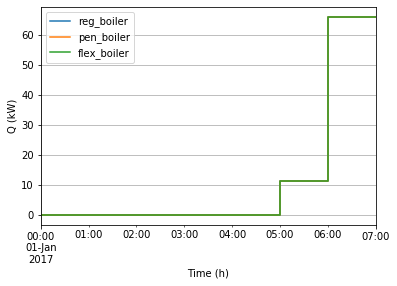

,reg_boiler,pen_boiler,flex_boiler,schedule_flex,schedule
2017-01-01 00:00:00,0.0,0.0,0.0,NaN,300
2017-01-01 01:00:00,0.0,0.0,0.0,20.0,30
2017-01-01 02:00:00,0.0,0.0,0.0,NaN,10
2017-01-01 03:00:00,0.0,0.0,0.0,NaN,300
2017-01-01 04:00:00,0.0,0.0,0.0,100.0,120
2017-01-01 05:00:00,0.0,0.0,0.0,30.0,120
2017-01-01 06:00:00,11.2,11.2,11.2,10.0,50
2017-01-01 07:00:00,66.0,66.0,66.0,100.0,10


In [10]:
ax = all_activities.plot(kind='line', drawstyle='steps-pre', grid=True)
ax.set_xlabel('Time (h)')
ax.set_ylabel('Q (kW)')
plt.show()
all_activities["schedule_flex"]=schedule_flex
all_activities["schedule"]=schedule
all_activities

## View storage capacities compared to demand and boiler activity



#### REGULAR HEAT FLOWS COMPARED TO DEMAND (AREA PLOT) ####




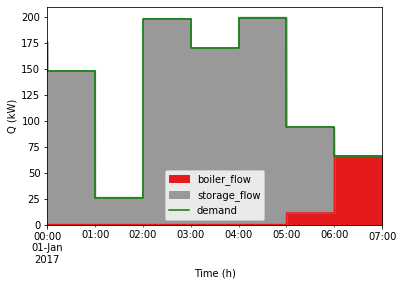

In [11]:
print("\n\n#### REGULAR HEAT FLOWS COMPARED TO DEMAND (AREA PLOT) ####\n\n")
stor_boil_flow_reg = prep_area_plot(tot_flow_reg)
ax = stor_boil_flow_reg.plot(kind="area", colormap = "Set1")
ax.set_xlabel('Time (h)')
ax.set_ylabel('Q (kW)')
demand.plot(kind = "line", drawstyle='steps-pre', ax=ax, linewidth=1.5, color = "GREEN")
plt.show()
tot_flow_reg
stor_boil_flow_pen = prep_area_plot(tot_flow_pen)



#### PENALTY HEAT FLOWS COMPARED TO DEMAND (AREA PLOT) ####




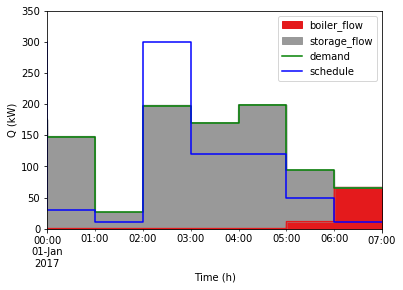

,storage_flow,boiler_flow,schedule,total_heat_flow,demand
2017-01-01 00:00:00,176.0,0.0,300,176.0,176.0
2017-01-01 01:00:00,148.0,0.0,30,148.0,148.0
2017-01-01 02:00:00,26.0,0.0,10,26.0,26.0
2017-01-01 03:00:00,198.0,0.0,300,198.0,198.0
2017-01-01 04:00:00,170.0,0.0,120,170.0,170.0
2017-01-01 05:00:00,199.2,0.0,120,199.2,199.2
2017-01-01 06:00:00,82.8,11.2,50,94.0,94.0
2017-01-01 07:00:00,0.0,66.0,10,66.0,66.0


In [12]:
print("\n\n#### PENALTY HEAT FLOWS COMPARED TO DEMAND (AREA PLOT) ####\n\n")
stor_boil_flow_pen = prep_area_plot(tot_flow_pen)
ax = stor_boil_flow_pen[stor_boil_flow_pen.columns.difference(['schedule'])].plot(kind="area", colormap = "Set1")
ax.set_xlabel('Time (h)')
ax.set_ylabel('Q (kW)')
demand.plot(kind = "line", drawstyle='steps-pre', ax=ax, linewidth=1.5, color = "GREEN", ylim=(0,350))
schedule_df.plot(kind = "line", drawstyle='steps-pre', ax=ax, linewidth=1.5, color = "BLUE")
plt.show()
tot_flow_pen



#### FLEXIBLE HEAT FLOWS COMPARED TO DEMAND (AREA PLOT) ####




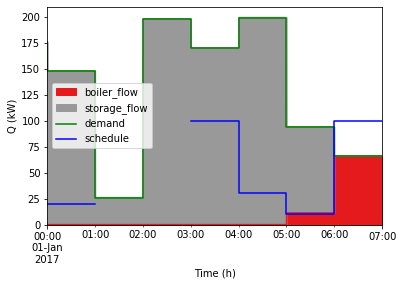

,storage_flow,boiler_flow,schedule,total_heat_flow,demand
2017-01-01 00:00:00,176.0,0.0,NaN,176.0,176.0
2017-01-01 01:00:00,148.0,0.0,20.0,148.0,148.0
2017-01-01 02:00:00,26.0,0.0,NaN,26.0,26.0
2017-01-01 03:00:00,198.0,0.0,NaN,198.0,198.0
2017-01-01 04:00:00,170.0,0.0,100.0,170.0,170.0
2017-01-01 05:00:00,199.2,0.0,30.0,199.2,199.2
2017-01-01 06:00:00,82.8,11.2,10.0,94.0,94.0
2017-01-01 07:00:00,0.0,66.0,100.0,66.0,66.0


In [13]:
print("\n\n#### FLEXIBLE HEAT FLOWS COMPARED TO DEMAND (AREA PLOT) ####\n\n")
stor_boil_flow_flex = prep_area_plot(tot_flow_flex)
ax = stor_boil_flow_flex[stor_boil_flow_flex.columns.difference(['schedule'])].plot(kind="area", colormap = "Set1")
ax.set_xlabel('Time (h)')
ax.set_ylabel('Q (kW)')
demand.plot(kind = "line", drawstyle='steps-pre', ax=ax, linewidth=1.5, color = "GREEN")
schedule_flex_df.plot(kind = "line", drawstyle='steps-pre', ax=ax, linewidth=1.5, color = "BLUE")
plt.show()
tot_flow_flex

The excess of the boiler heat production during the last timestep was stored into the storage:

In [14]:
h2stor_flex = results[(b_th_flex, storage_th_flex)]["sequences"]
h2stor_flex

variable_name,flow
2017-01-01 00:00:00,0.0
2017-01-01 01:00:00,0.0
2017-01-01 02:00:00,0.0
2017-01-01 03:00:00,0.0
2017-01-01 04:00:00,0.0
2017-01-01 05:00:00,0.0
2017-01-01 06:00:00,0.0
2017-01-01 07:00:00,0.0
